In [1]:
# Для использования только CPU.

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [2]:
# Подгружаем нужные библиотеки.

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math

C:\Users\grimy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\grimy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\grimy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\grimy\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passi

In [3]:
# Выводим текущую версию tensorflow.

print("Tensorflow version \n" + tf.__version__)

Tensorflow version 
1.14.0


In [4]:
# Проверяем обнаруживает ли GPU.

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [5]:
# Выводим версию CUDA.

# !nvcc --version

In [6]:
# Без этого весь tensorflow тонет в ошибках, скорее всего из-за слишком новой версии numpy.

# tf.enable_eager_execution(
#     config=None,
#     device_policy=None,
#     execution_mode=None
# )

tf.enable_eager_execution()

In [7]:
%matplotlib inline

In [8]:
# Настройки гиперпараметров.

NUM_EPOCHS = 4 # Количество эпох.
BATCH_SIZE = 256 # Количество картинок за одну эпоху.
LEARNING_RATE = 0.0008 # Скорость обучения (Доля градиента, по которой веса обновляются на каждой итерации цикла обучения.)

In [9]:
# Загружаем данные.

(train_x, train_y), (test_x, test_y) = tf.keras.datasets.mnist.load_data()

In [10]:
print(train_x.shape, train_x.dtype)

(60000, 28, 28) uint8


In [11]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28) uint8
(60000,) uint8
(10000, 28, 28) uint8
(10000,) uint8


In [12]:
# Преобразуем загруженные данные.

train_x = train_x.reshape(-1, 28, 28, 1).astype(np.float32)/255.
test_x = test_x.reshape(-1, 28, 28, 1).astype(np.float32)/255.

train_y = train_y.astype(np.int32)
test_y = test_y.astype(np.int32)

In [13]:
print(train_x.shape, train_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_x.shape, test_x.dtype)
print(test_y.shape, test_y.dtype)

(60000, 28, 28, 1) float32
(60000,) int32
(10000, 28, 28, 1) float32
(10000,) int32


In [14]:
# Берем 100 картинок из примеров.

test_samples = train_x[:100, ...]

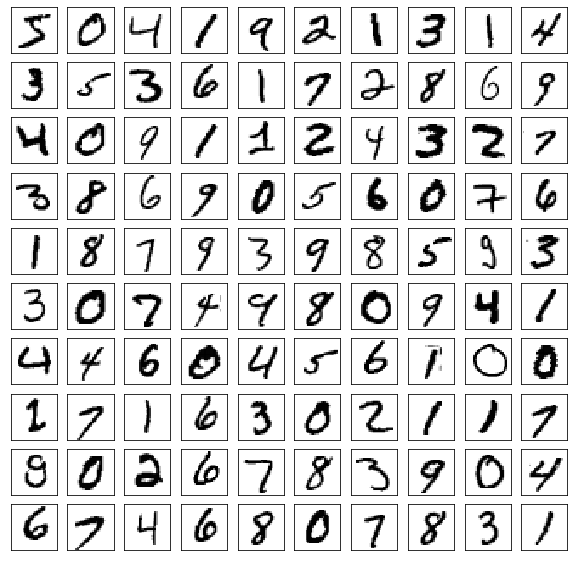

In [15]:
# Показываем выбранные картинки.

fig = plt.figure(figsize=(10, 10))
for j in range(test_samples.shape[0]):
    ax = fig.add_subplot(10, 10, j+1)
    ax.imshow(test_samples[j, :, :, 0], cmap=plt.cm.binary) # или cmap = "gray".
    plt.xticks([]), plt.yticks([])

In [16]:
# Преобразуем данные в датасерт.

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [17]:
# Создаем функцию модели.

class Model(tf.keras.Model):

    def __init__(self):
        super(Model, self).__init__()
        self.Conv1 = tf.layers.Conv2D(32, (5, 5), activation=tf.nn.relu, padding="same")
        self.Conv2 = tf.layers.Conv2D(64, (5, 5), activation=tf.nn.relu, padding="same")
        self.Fc1 = tf.layers.Dense(256, activation=tf.nn.relu)
        self.Fc2 = tf.layers.Dense(10)
        self.MaxPooling = tf.layers.MaxPooling2D((2, 2), (2, 2), padding="same")

    def __call__(self, inp):
        out = self.Conv1(inp)
        out = self.MaxPooling(out)
        out = self.Conv2(out)
        out = self.MaxPooling(out)
        out = tf.layers.flatten(out)
        out = self.Fc1(out)
        out = self.Fc2(out)
        return out

In [18]:
model = Model()

In [19]:
# Создаем функицю потери (функция ошибки, сравнивающая выводы нейронной сети с правильными ответами).

def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels))

# Создаем функицю точности.

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32)
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

In [20]:
# Устанавливаем оптимизатор.

#optimazer = tf.train.GradientDescentOptimizer(LEARNING_RATE)
optimazer = tf.train.AdamOptimizer(LEARNING_RATE)

In [21]:
# Задаем глобальный шаг.

global_step = tf.train.get_or_create_global_step()

In [22]:
%%time
for (images, labels) in train_ds:

    # Прямое распространение.
    
    with tf.GradientTape() as tape:
        logits = model(images)
        loss_value = loss(logits, labels)
        
    # Обратное распространение.
    
    grads = tape.gradient(loss_value, model.variables)
    optimazer.apply_gradients(zip(grads, model.variables), global_step=global_step)

    if global_step.numpy() % 200 == 0:
        test_logits = model(test_x[:256, ...])
        accuracy_value = accuracy(test_logits, test_y[:256, ...])
        print(f"[{global_step.numpy()}] Accuracy: {accuracy_value.numpy()*100}")

Instructions for updating:
Use keras.layers.flatten instead.
[200] Accuracy: 99.21875
[400] Accuracy: 100.0
[600] Accuracy: 99.609375
[800] Accuracy: 100.0
Wall time: 4min 12s


In [23]:
# Подсчитываем финальную точность.

test_logits = model(test_x)
accuracy_value = accuracy(test_logits, test_y).numpy()
print(f"Final Accuracy:{accuracy_value*100}%")

Final Accuracy:99.01999831199646%


In [24]:
# Создаем функицю проверки цифры.

def test_digit(sample):

    sample = sample[np.newaxis, ...]
    logits = model(sample)
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)

    fig = plt.figure(figsize=(12, 4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample[0, :, :, 0], cmap=plt.cm.binary)
    plt.xticks([]), plt.xticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction[0], align="center")
    bar_list[ans].set_color("g")
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()

    print(f"Predicted:{ans}")

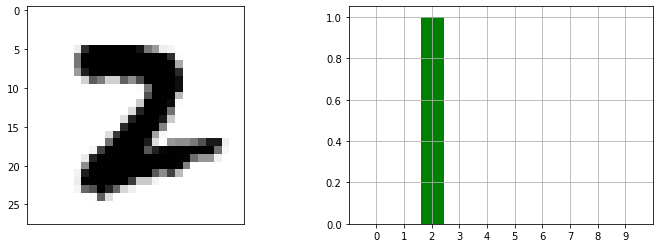

Predicted:2
Right answer:2


In [25]:
# Выводим картинку случайно выбранной цифры и предсказания нейросети.

import random

idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_digit(sample)

print(f"Right answer:{test_y[idx]}")